
# Recurrent neural networks to recognize entities in texts



Developed by Kevin Reyes - Diego Quezada.


In [54]:
import random


In [55]:
os.environ["PYTHONHASHSEED"] = "0"
np.random.seed(1)
random.seed(1)


In [56]:
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
tf.compat.v1.set_random_seed(1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)



# NN over text

 Today, a relevant application of recurrent neural networks is text and natural language modeling. In this work we will address the problem of processing text sentences, provided by GMB ( *Groningen Meaning Bank* ), for entity recognition and tagger. Specifically, we will work with the dataset provided through **[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)** , which is made up of more than a million words, in order to make predictions on different tasks such as *many to many* and *many to one* .

 <img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />



## a) Data loading and pre-processing



**Dataset Comments:**

 The original task of the dataset was to identify named (or tagged) features from text, particularly features such as name and location.
 The variable we seek to predict is the entity or entities that participate in a sentence. this refers to identifying crucial information or of interest
 of a text. A dictionary would not suffice because it would give us limited information that would not be considered a recurrent architecture. The latter allows us to identify entities of interest in
 complex sentences where the entity is not explicit, so it is not possible to obtain a correct prediction from a simple dictionary.
 In this first instance we will work with the task of performing a NER *tag* ( **Named Entity Recognition** ) on each of the words in the sentences that are presented to us in the data. This task is of type *many to many* , that is, the input is a sequence and the output is a sequence, without *shift* , so we will need a suitable network structure for this. First we will extract the columns that we will use from the dataset.

 **Comments:**

 We will use the lemmatization of each word since each word can have multiple variations, for example, *working* in English in the different
 times and people could be: work, worked, working and works, each of these words has
 the same meaning but in a different time or person, so it is useful to use
 lemmatization to bring all the words to their root and thus get the most out of it
 to learning, since, instead of having to learn work, worked, working and works, we will be
 learning work and its use can be interpreted given the context, this is useful for our
 specific problem, since, to recognize entities in a sequence it is not relevant
 the time or the person used.


In [57]:
import matplotlib.pyplot as plt
import tensorflow as tf


In [58]:
username="diegoquezada21"
key="afb1882970f4ac5726f12dda7bf92f7c"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
if not os.path.exists("/content/NER"):
    os.makedirs("/content/NER")
os.chdir('/content/NER')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls


entity-annotated-corpus.zip: Skipping, found more recently modified local copy (use --force to force download)
entity-annotated-corpus.zip  ner.csv  ner_dataset.csv


In [59]:
import numpy as np
import pandas as pd

df_ner = pd.read_csv("ner.csv", encoding="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
dataset = df_ner.loc[:, ["lemma", "tag", "word", "sentence_idx"]]
dataset[0:200]


b'Skipping line 281837: expected 25 fields, saw 34\n'


,lemma,tag,word,sentence_idx
0,thousand,O,Thousands,1.0
1,of,O,of,1.0
2,demonstr,O,demonstrators,1.0
3,have,O,have,1.0
4,march,O,marched,1.0
...,...,...,...,...
195,.,O,.,9.0
196,iranian,B-gpe,Iranian,10.0
197,offici,O,officials,10.0
198,say,O,say,10.0



##### II) In order to use this data set, we must transform our table of words and sentences, to a table where each entry is a sentence, also encoding the different lemmas and tags as numerical values. This could be done with one of the keras or sklearn utilities, however the following code proposes a method only using python and pandas.


In [60]:
import numpy as np

# Crea un diccionario donde a cada lemma se le asigna un código numérico partiendo desde el 1
lemma_to_code = {lemma: code + 1 for code, lemma in enumerate(dataset.lemma.unique())}
# Crea un diccionario donde a cada tag se le asigna un código numérico partiendo desde el 1
tag_to_code = {tag: code + 1 for code, tag in enumerate(dataset.tag.unique())}
# Calcula la cantidad de lemmas
n_lemmas = len(lemma_to_code)
lemmas = dataset.lemma.unique()
tags = dataset.tag.unique()
# cambia el valor de cada registro de lemma en el dataset por el código numérico generado
dataset["lemma"] = dataset.lemma.apply(lambda x: lemma_to_code[x])
# cambia el valor de cada registro de tag en el dataset por el código numérico generado
dataset["tag"] = dataset.tag.apply(lambda x: tag_to_code[x])

# Primero las palabras se agrupan por la sentencia a la que pertenecen
# Cada grupo se transforma en una lista y luego se convierte en un array de numpy
dff = dataset.groupby("sentence_idx")[["lemma", "tag"]].agg(list).applymap(np.asarray)



## b) Distributions.

 Now that we have the sentences encoded and grouped, we will explore the size of these, in number of lemmas.

 **Answer:** Not all sentences are the same size, this makes sense because in practice you will not work with sentences of the same length.
 When training RNN&#39;s it is necessary to define the form of the input, however these do not depend on the length of the sequence when inferring.
 The problems that this could cause occur in training, when there is not a perfect match between the size of each input with the total length.
 of the sequence so that at some point the network must be fed with an input of different dimensions, in these cases it can be **truncated** or used **padding** .

 It is highlighted that the classes are not distributed equally, sentences with a length of approximately 20 words are overrepresented.

 **Zipf Law (law on the distribution of words):** Indeed we can observe the Zipf law. This is evidenced in our last graph in this section, where we see that
 By plotting the lemmas according to their frequency from highest to lowest, we obtain a function with the same behavior as one of the form $\displaystyle f(x) = \frac{1}{x^a}$


In [61]:
print(n_lemmas)
n_tags = len(tag_to_code)
print(n_tags)
# print(dff['lemma'].applymap(len))
largos_sentencias = list(map(len, dff["lemma"].tolist()))


20243
17


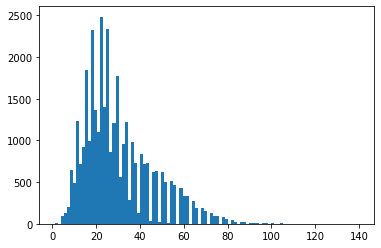

In [62]:
plt.hist(largos_sentencias, bins=100)
plt.show()


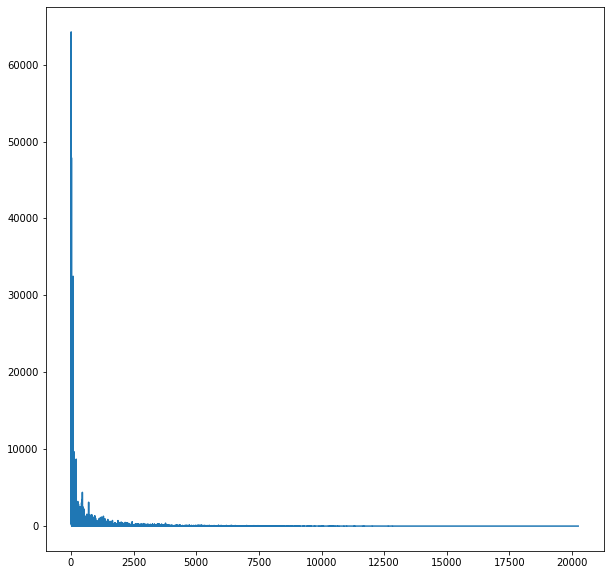

In [63]:
%matplotlib inline
lemma_frequence_2 = (
    pd.Series(np.concatenate([x for x in dff["lemma"]])).value_counts().sort_index()
)
# plt.hist(lemma_frequence_2.values,bins = lemma_frequence_2.index.map(str))
# plt.hist(lemma_frequence_2.values, bins = lemma_frequence_2.index.to_numpy())
lemma_frequence_2.plot(figsize=(10, 10))



## c) Padding and one hot vectors



##### I) Next, we will transform the lemma sequences (and the corresponding tags) so that they all have the same length, that is, we will apply padding. The padding will be done with the value 0.

 **Comments:**

 In English, Spanish and other languages, grammatically the entities
 are usually named at the beginning of sentences, for example, "The organization achieved its
 objectives this year". Therefore, we should ensure that the neurons that receive
 the initial part of the sentences work with valid data, for this we will apply the padding at the end of the sentence.

 The padding value, in this case zero, must be chosen depending on the dictionary, in our case the numerical encoding
 of the lemmas starts from 1, so when padding we must avoid
 use a number that is part of the lemmas, since, in that case, we would be adding
 words with meaning to the sentence, when using the 0 that is not part of the dictionary
 we are adding a neutral element.


In [64]:
mean_sentencias = sum(largos_sentencias) / len(largos_sentencias)
print(mean_sentencias)


29.871620661227507


In [65]:
from keras.preprocessing.sequence import pad_sequences

max_len = 30  # Promedio de largos de secuencias
X = pad_sequences(
    dff["lemma"], maxlen=max_len, padding="post"
)  # 0 al inicio por default
Y = dff["tag"].values
Y = pad_sequences(Y, maxlen=max_len, padding="post")  # 0 al inicio por default



##### II) In order to provide a classification of the different *tags* , it is necessary to transform them into *one hot vectors* , since they are encoded in integers, this will result in a three-dimensional array with the number of examples, the maximum number of words and the number of possible *tags* .

 **Comments:**

 **Input dimensions:** For the training set we have 26382 examples and to validate we have 8795 , where each one is an array of 30 lemmas, that is,
 a numerically encoded statement.

 **Output dimensions:** For the training set we have 26382 examples and to validate we have 8795 , where each output element is an array with the
 complete statement, which in turn each element of the statement has an associated array of dimension 18 (it should be 17, but due to a keras error, 1 was added to the length of the one-hot-vector),
 which has in the element $i$ the probability that this lemma is of the class/tag $i$


In [66]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

y = np.asarray([to_categorical(i, num_classes=n_tags + 1) for i in Y])


In [67]:
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)


In [68]:
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape


((26382, 30), (26382, 30, 18), (8795, 30), (8795, 30, 18))


## d) RNN many to many



##### I) We will use a *many to many* recurrent neural network with LSTM gates to learn how to *tag* the entity in the text. This network must process the sequence of filled (or unfilled) *lemmas* and deliver the *tag* to each of the *lemmas* , so the output of the network is not a vector as previously worked, but has an extra dimension: which is because at each instant of time an *output* needs to be delivered. As the *lemmas* correspond to essentially categorical, or at least discrete, data, it is necessary to generate a vector representation of them. The first layer of the network to be built must therefore include a trainable transformation from the original (discrete) representation space to ${\rm I!R}^{d}$ , with $d$ the dimensionality of the *embedding* .

 **Comments:**
1.  Input -&gt; [30].
1.  Embedding -&gt; [30, 32]
1.  LSTM -&gt; [30, 128]
1.  Give yourself -&gt; [30,18]

 When inputting a sequence to embedding, each lemma in the sequence is converted to a 32-dimensional vector representation, so the output is a sequence of length 30
 where each element is a vector of 32. This sequence is fed to the LSTM, which returns a sequence of 30 elements (return_sequences=True), where each
 element has the output of all 128 cells of the LSTM. Finally this feeds into the dense layer, which returns the sequence of 30 elements, where each element
 is a vector of length 18 (17+1), where the element $i$ of the vector represents the probability of the lemma being of the tag $i$.


In [69]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

x_tr = np.asarray(x_tr).astype("float32")
x_val = np.asarray(x_val).astype("float32")
max_len = 30

# ¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
m = Sequential()
embedding_dim = 32
m.add(Embedding(input_dim=n_lemmas + 1, output_dim=embedding_dim, input_length=max_len))
m.add(LSTM(units=128, return_sequences=True))
m.add(Dense(n_tags + 1, activation="softmax"))
m.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
# history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)


In [70]:
m.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 32)            647808    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           82432     
_________________________________________________________________
dense_3 (Dense)              (None, 30, 18)            2322      
Total params: 732,562
Trainable params: 732,562
Non-trainable params: 0
_________________________________________________________________


In [71]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [72]:
# pip install sklearn-crfsuite



To evaluate the model we will use a suitable metric for the imbalance present between the classes.


In [95]:
from sklearn_crfsuite.metrics import flat_classification_report


y_pred = m.predict(x_val)
y_pred = y_pred > 0.5


print(flat_classification_report(y_val, y_pred))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.87      0.95      0.91    152888
           1       0.98      0.91      0.94    206567
           2       0.84      0.49      0.62      8734
           3       0.99      0.09      0.16      3771
           4       0.82      0.19      0.30      3633
           5       0.71      0.12      0.21      1700
           6       0.00      0.00      0.00      4577
           7       0.00      0.00      0.00      3712
           8       0.95      0.49      0.65      4643
           9       0.00      0.00      0.00        83
          10       0.00      0.00      0.00        55
          11       0.63      0.56      0.60      3717
          12       0.00      0.00      0.00        43
          13       1.00      0.03      0.06      1409
          14       0.00      0.00      0.00        60
          15       0.00      0.00      0.00        84
          16       0.00      0.00      0.00        76
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



##### II) We will modify the dimensionality of the initial embedding and determine if it **increases or decreases the classification error**

 **Comments:**

 When experimenting with dimensionalities greater than 30 for the embedding we do not obtain a considerable improvement based on the
 precision by weighted average. With a dimensionality of 25 we obtain results practically the same as those obtained with 30, however
 by starting to further decrease the dimensionality of the embeddng we get worse results. This is clear then
 we are excessively reducing the dimensionality of the mathematical representation of our vocabulary (lemmas), so the embedding layer fails to learn
 all the patterns between the lemmas of the dataset, that is, from a certain dimension downwards, a problem of underfitting of the vocabulary used appears.


In [74]:
# ¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
m = Sequential()
embedding_dim = 25
m.add(Embedding(input_dim=n_lemmas + 1, output_dim=embedding_dim, input_length=max_len))
m.add(LSTM(units=128, return_sequences=True))
m.add(Dense(n_tags + 1, activation="softmax"))
m.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
history = m.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=3, batch_size=128)


Epoch 1/3
207/207 [==============================] - 5s 16ms/step - loss: 1.4532 - acc: 0.7412 - val_loss: 0.4648 - val_acc: 0.8822
Epoch 2/3
207/207 [==============================] - 3s 13ms/step - loss: 0.3986 - acc: 0.8913 - val_loss: 0.2957 - val_acc: 0.9137
Epoch 3/3
207/207 [==============================] - 3s 14ms/step - loss: 0.2712 - acc: 0.9232 - val_loss: 0.2270 - val_acc: 0.9433


In [75]:
y_pred = m.predict(x_val)
y_pred = y_pred > 0.5
print(flat_classification_report(y_val, y_pred))  # , labels=tag_to_code))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54637
           1       0.97      0.98      0.98    178340
           2       0.86      0.52      0.65      7537
           3       0.99      0.12      0.21      3143
           4       0.82      0.22      0.34      3033
           5       0.72      0.13      0.22      1482
           6       0.00      0.00      0.00      3821
           7       0.00      0.00      0.00      3139
           8       0.96      0.58      0.72      4017
           9       0.00      0.00      0.00        68
          10       0.00      0.00      0.00        44
          11       0.82      0.57      0.67      3121
          12       0.00      0.00      0.00        33
          13       1.00      0.03      0.06      1228
          14       0.00      0.00      0.00        50
          15       0.00      0.00      0.00        72
          16       0.00      0.00      0.00        64
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



## e) Bidirectional RNN and masking



##### I) Some authors point out the important dependency that exists in the text, not only with the previous words, but also with the following ones. **We will improve the network defined in 2.dI) using a Bidirectional recurrent neural network** , that is, with recurrence in both directions on the input *lemma* sequence.

 We get better results using the merge_mode parameter in sum. This is because, as stated above, the most relevant information is obtained by moving from the beginning to the end (forward), so that if, for example, we use mult and the past indicates a probability close to 1, while the future (backward) a close to zero when doing merge we will get an output close to zero. When using sum we simply take the probability that the past tells us (forward) for cases where the future tells us a probability close to 0. Note also that using concat does not discard information because we do not do a merge as such, in fact , increases the dimensionality of the LSTM output and the task of identifying the importance weightings falls on the dense layer, however, for this application this results in an unnecessary expenditure of computational resources.

 Using this type of network slightly decreased performance. In problems like predicting the next word in a sentence, it is really useful to know the future context (what is expected to be said after the word to be predicted), whereas in the entity type prediction problem, given the way that we structure language normally words
 that we used before allow us to more easily recognize an entity that will be named. In example 1, we note how before mentioning **Hyde Park**
 the word **in** is used, which is a recurring pattern when talking about a physical place with certain characteristics (in English), the words that
 appear after **Hyde Park** , they are not really useful, since they are very specific, so they will not help to improve the generalization capacity of the model.
 In example 2, we see the same for **Britain&#39;s** , the word **of** is a typical pattern before mentioning a B-Geo, the same rule can be applied for
 the rest of the words in bold, usually the most important thing to recognize the type of an entity is in the past context of the sentence.

 Examples:
1.  They marched from the houses of parliament to a rally in **Hyde Park** . Police put the number of marchers at 10,000...
1.  the annual conference of **Britain&#39;s** ruling **Labor Party** in the **southern English** seaside resort of Brighton. The party is...


In [76]:
from keras.layers import Bidirectional

model = Sequential()
model.add(
    Embedding(input_dim=n_lemmas + 1, output_dim=embedding_dim, input_length=max_len)
)
layer_lstm = LSTM(units=128, return_sequences=True)
model.add(
    Bidirectional(layer_lstm, merge_mode="concat")
)  # 'sum', 'mul', 'concat', 'ave'
model.add(Dense(n_tags + 1, activation="softmax"))
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
history = model.fit(
    x_tr, y_tr, validation_data=(x_val, y_val), epochs=3, batch_size=128
)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 25)            506100    
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           157696    
_________________________________________________________________
dense_5 (Dense)              (None, 30, 18)            4626      
Total params: 668,422
Trainable params: 668,422
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 7s 21ms/step - loss: 1.2446 - acc: 0.7559 - val_loss: 0.3945 - val_acc: 0.8862
Epoch 2/3
207/207 [==============================] - 3s 16ms/step - loss: 0.3403 - acc: 0.9000 - val_loss: 0.2329 - val_acc: 0.9350
Epoch 3/3
207/207 [==============================] - 3s 16ms/step - loss: 0.1984 - acc: 0.9452 - val_loss: 0.1616 

In [77]:
y_pred_2e = model.predict(x_val)
y_pred_2e = y_pred_2e > 0.5
print(flat_classification_report(y_val, y_pred_2e))  # , labels=tag_to_code))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54637
           1       0.98      0.98      0.98    178340
           2       0.86      0.69      0.76      7537
           3       0.95      0.87      0.91      3143
           4       0.83      0.54      0.66      3033
           5       0.79      0.45      0.58      1482
           6       0.90      0.18      0.30      3821
           7       0.83      0.13      0.23      3139
           8       0.92      0.72      0.81      4017
           9       0.00      0.00      0.00        68
          10       0.00      0.00      0.00        44
          11       0.81      0.69      0.75      3121
          12       0.00      0.00      0.00        33
          13       0.81      0.37      0.50      1228
          14       0.00      0.00      0.00        50
          15       0.00      0.00      0.00        72
          16       0.00      0.00      0.00        64
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



##### II) The *Masking* layer has recently been implemented in recurrent networks in *keras* , which could bring great help thanks to the *padding* that is done with the special symbol defined. We will train the network defined in 2.dI).

 **Comments:**

 By using mask_zero = True we get worse performance, apparently it doesn&#39;t work for us because we applied it wrongly. However, we can also mask the value 0 by adding a Masking layer after the Embedding, for this case we did get better results.

 Using Masking we obtain for the weighted average the values 0.97, 0.96 and 0.96. For the model of question 2.dI we obtain the values 0.91, 0.87 and 0.87.

 This improvement is to be expected because, unlike the previous model, now we are not taking into account the zeros introduced by padding in learning, that is, we are reducing a source of error in the data.


In [185]:
from keras.layers import Masking

m_2e2 = Sequential()
m_2e2.add(Embedding(input_dim=n_lemmas + 1, output_dim=embedding_dim))
m_2e2.add(Masking(mask_value=0.0))
m_2e2.add(LSTM(units=128, return_sequences=True))
m_2e2.add(Dense(n_tags + 1, activation="softmax"))
m_2e2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
history = m_2e2.fit(
    x_tr, y_tr, validation_data=(x_val, y_val), epochs=3, batch_size=128
)


Epoch 1/3
207/207 [==============================] - 13s 41ms/step - loss: 1.1027 - acc: 0.8324 - val_loss: 0.2714 - val_acc: 0.9259
Epoch 2/3
207/207 [==============================] - 7s 35ms/step - loss: 0.2342 - acc: 0.9354 - val_loss: 0.1548 - val_acc: 0.9591
Epoch 3/3
207/207 [==============================] - 7s 35ms/step - loss: 0.1330 - acc: 0.9644 - val_loss: 0.1176 - val_acc: 0.9669


In [186]:
y_pred_2e2 = m_2e2.predict(x_val)
y_pred_2e2 = y_pred_2e2 > 0.5
print(flat_classification_report(y_val, y_pred_2e2))  # , labels=tag_to_code))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152888
           1       0.97      0.99      0.98    206567
           2       0.85      0.72      0.78      8734
           3       0.96      0.87      0.91      3771
           4       0.83      0.66      0.73      3633
           5       0.85      0.49      0.62      1700
           6       0.79      0.36      0.49      4577
           7       0.75      0.36      0.49      3712
           8       0.92      0.72      0.81      4643
           9       0.00      0.00      0.00        83
          10       0.00      0.00      0.00        55
          11       0.83      0.83      0.83      3717
          12       0.00      0.00      0.00        43
          13       0.83      0.44      0.58      1409
          14       0.00      0.00      0.00        60
          15       0.00      0.00      0.00        84
          16       0.00      0.00      0.00        76
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



## f) Free improvement

 Based on what has been experienced, we will try to improve the performance of the networks found.


In [80]:
mean_sentencias = sum(largos_sentencias) / len(largos_sentencias)
std = np.std(largos_sentencias)
max_len = round(mean_sentencias + std.item())  # Promedio de largos de secuencias
X = pad_sequences(
    dff["lemma"], maxlen=max_len, padding="pre"
)  # 0 al inicio por default
# X
Y = dff["tag"].values
Y = pad_sequences(Y, maxlen=max_len, padding="pre")  # 0 al inicio por default
y = np.asarray([to_categorical(i, num_classes=n_tags + 1) for i in Y])
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)


In [81]:
tf.keras.backend.clear_session()
from keras.layers import Embedding, Dense, GRU

m_2f1 = Sequential()
m_2f1.add(
    Embedding(input_dim=n_lemmas + 1, output_dim=embedding_dim, input_length=max_len)
)  ##,mask_zero=True))
m_2f1.add(GRU(units=128, return_sequences=True))
m_2f1.add(Dense(n_tags + 1, activation="softmax"))
m_2f1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
history = m_2f1.fit(
    x_tr, y_tr, validation_data=(x_val, y_val), epochs=3, batch_size=128
)


Epoch 1/3
207/207 [==============================] - 5s 17ms/step - loss: 1.3249 - acc: 0.7191 - val_loss: 0.2933 - val_acc: 0.9198
Epoch 2/3
207/207 [==============================] - 3s 14ms/step - loss: 0.2487 - acc: 0.9317 - val_loss: 0.1708 - val_acc: 0.9536
Epoch 3/3
207/207 [==============================] - 3s 14ms/step - loss: 0.1501 - acc: 0.9597 - val_loss: 0.1282 - val_acc: 0.9651


In [82]:
from sklearn_crfsuite.metrics import flat_classification_report

y_pred_2f1 = m_2f1.predict(x_val)
y_pred_2f1 = y_pred_2f1 > 0.5
print(flat_classification_report(y_val, y_pred_2f1))  # , labels=tag_to_code))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152888
           1       0.97      0.99      0.98    206567
           2       0.83      0.75      0.79      8734
           3       0.96      0.86      0.91      3771
           4       0.88      0.47      0.62      3633
           5       0.88      0.41      0.56      1700
           6       0.92      0.24      0.38      4577
           7       0.89      0.16      0.27      3712
           8       0.92      0.74      0.82      4643
           9       0.00      0.00      0.00        83
          10       0.00      0.00      0.00        55
          11       0.84      0.72      0.78      3717
          12       0.00      0.00      0.00        43
          13       0.90      0.36      0.52      1409
          14       0.00      0.00      0.00        60
          15       0.00      0.00      0.00        84
          16       0.00      0.00      0.00        76
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
# 221
example = 211
pred_form = [
    np.where(x == True)[0][0] - 1 if len(np.where(x == True)[0]) else 0
    for x in y_pred_2f1[example]
]
for i in range(len(x_val[example])):
    if x_val[example][i] == 0:
        continue
    print(
        f"El tag predecido para el lemma {lemmas[x_val[example][i]-1]} es: {tags[pred_form[i]]}"
    )


El tag predecido para el lemma on es: O
El tag predecido para el lemma sunday es: B-tim
El tag predecido para el lemma , es: O
El tag predecido para el lemma the es: O
El tag predecido para el lemma u.s. es: B-geo
El tag predecido para el lemma militari es: O
El tag predecido para el lemma said es: O
El tag predecido para el lemma it es: O
El tag predecido para el lemma had es: O
El tag predecido para el lemma kill es: O
El tag predecido para el lemma 15 es: O
El tag predecido para el lemma to es: O
El tag predecido para el lemma 20 es: O
El tag predecido para el lemma suspect es: O
El tag predecido para el lemma taleban es: B-org
El tag predecido para el lemma fighter es: O
El tag predecido para el lemma in es: O
El tag predecido para el lemma an es: O
El tag predecido para el lemma airstrik es: O
El tag predecido para el lemma after es: O
El tag predecido para el lemma coalit es: O
El tag predecido para el lemma forc es: O
El tag predecido para el lemma came es: O
El tag predecido pa


## g) Let&#39;s write words



##### I) Now we will look for another application to the recurrent networks, predict the next character. If we manage to train a network that is good at this task, we will be able to write text automatically, since we can, from a sentence, predict the next character, and then introduce the new sentence without the first character in the network again, and iterating thus to write automatically. Although recurrent networks are adequate for this task, we do not intend to train a Shakespeare, however it is interesting to investigate how plausible the generated text can be.

 For this, we will create our new dataset. For this task we will prefer to join all the sentences in a single large corpus and then create new semi-redundant sequences. This avoids us first of all the problem of having to do padding, since we will create all the entries the same, but it also allows us to take better advantage of the dataset, in a certain way increasing the number of data. The target in this case will only be the next character corresponding to each sequence.


In [84]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical

# Cargamos el dataframe
df_w = pd.read_csv(os.path.join("ner.csv"), engine="python", error_bad_lines=False)
# Elimina todos los registros con valores nan y toma la columna word
df_w = df_w.dropna()[["word"]]

corpus = " ".join(
    list(df_w.word.values)
).lower()  # unimos todas las "palabras" en minuscula en un gran string
sentence_length = 40  # definimos el largo de la secuencia
steps = 5  # definimos el salto entre sentencia y sentencia, como es menor que 40 iremos repitiendo caracteres

# Lista para guardas las sentencias
sentences = []
# Lista para guardar los caracteres siguientes
next_char = []
# Itera sobre el corpus que contiene todas las palabras en minúscula con pasos de a 5 palabras
for i in range(0, len(corpus) - sentence_length - 1, steps):
    # Arma las sentencias con el largo de la sentencia definido previamente, se destaca que, al ser el largo de las secuencias mayor que el step, cada secuencia
    # contendrá palabras repetidas de sentencias anteriores
    sentences.append(corpus[i : sentence_length + i])
    # Se añade el siguiente caracter de la secuencia recién añadida, es decir, el valor a predecir
    next_char.append(corpus[sentence_length + i])

# Codificamos cada caracter presente en el corpus
chars_to_code = {char: code for code, char in enumerate(set(corpus))}
# Decodificamos cada codigo al caracter correspondiente
code_to_chars = {code: char for char, code in chars_to_code.items()}
# Codificamos cada sentencia de entrenamiento
x = np.array([[chars_to_code[char] for char in sentence] for sentence in sentences])
# Codificamos cada caracter de output para una sentencia en específico
y = np.array([chars_to_code[char] for char in next_char])
# Pasamosa a one hot vector las predicciones
y = to_categorical(y)


Skipping line 281837: Expected 25 fields in line 281837, saw 34



##### II) We will train a network with this data using GRU.

 If we were to train the network with a different dataset, the texts generated for the same initial sequence would be different. This is because in learning they would learn

 different relationships, thus obtaining models that behave differently when faced with the same output. For example, if we train a model

 With a dataset of movie opinions, it is expected that the generated texts are based mainly on the names of actresses, actors, movies, characters, etc.


In [85]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.callbacks import LambdaCallback
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import sys


def predict_char(model, sentence):
    x = [chars_to_code[char] for char in sentence]
    x = pad_sequences([x], maxlen=sentence_length, padding="pre", value=0)
    probas = model.predict(x)[0]
    next_index = np.random.choice(len(chars_to_code), p=probas)
    return code_to_chars[next_index]


def on_epoch_end(epoch, logs):
    print(f"\n Generating random text for epoch: {epoch}")
    start_index = random.randint(0, x.shape[0] - 1)
    sentence = "".join([code_to_chars[code] for code in x[start_index]])
    print("\n Generating with seed: " + sentence)
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_char(character, sentence)
        sentence = sentence[1:] + next_char  # for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return


print_text_callback = LambdaCallback(on_epoch_end=on_epoch_end)


In [86]:
character = Sequential()
embedding_dim = 100
character.add(
    Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1])
)
character.add(GRU(128, return_sequences=False))
character.add(Dense(y.shape[1], activation="softmax"))
optimizer = RMSprop(lr=0.01)
character.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])
character.fit(x, y, epochs=1, batch_size=512, callbacks=[print_text_callback])
character.summary()


2371/2371 [==============================] - 30s 12ms/step - loss: 1.8508 - acc: 0.4604

 Generating random text for epoch: 0

 Generating with seed: pine army camp , where u.s. soldiers and
pine army camp , where u.s. soldiers and fcoccement obchunters forced officiancens stand dri . decupted due willed days will near days on during friday porsman jodes for gaymaks say decoup , and forly misio has and killed stands wednsund fives elutivened trand to overivers three on tued injasas killed in legged tile runs officials mud days in the cancem for the terrists for nissing for dismonth in onew af quccad say that culoods jontiveModel: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           6000      
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               88320     
_________________

In [102]:
predicted_char = "the flowers are"
for i in range(100):
    predicted_char = predicted_char + predict_char(character, predicted_char)
print(predicted_char)


the flowers are mites for the dispressments in the gensons the outside fund days of the glans thats fromer bringin 


In [169]:
character_2 = Sequential()
embedding_dim = 100
character_2.add(
    Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1])
)
character_2.add(GRU(32, return_sequences=True))
character_2.add(GRU(128, return_sequences=False))
character_2.add(Dense(y.shape[1], activation="softmax"))
optimizer = RMSprop(lr=0.01)
character_2.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"]
)
character_2.fit(x, y, epochs=2, batch_size=512)
character_2.summary()


Epoch 1/2
2371/2371 [==============================] - 37s 15ms/step - loss: 1.8973 - acc: 0.4475
Epoch 2/2
2371/2371 [==============================] - 34s 15ms/step - loss: 1.6241 - acc: 0.5196
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_64 (Embedding)     (None, 40, 100)           6000      
_________________________________________________________________
gru_130 (GRU)                (None, 40, 32)            12864     
_________________________________________________________________
gru_131 (GRU)                (None, 128)               62208     
_________________________________________________________________
dense_67 (Dense)             (None, 60)                7740      
Total params: 88,812
Trainable params: 88,812
Non-trainable params: 0
_________________________________________________________________


In [178]:
predicted_char = "last year in france"
for i in range(100):
    predicted_char = predicted_char + predict_char(character_2, predicted_char)
print(predicted_char)


last year in francely citia . ghbern ivan cascaced of camicals in a peonzecparitia 's hospriciated instkreeptant groazw
